In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from collections import deque
import tensorflow as tf
from tqdm import tqdm_notebook, tqdm
sys.path.append(os.path.abspath(os.path.abspath(os.path.join('..'))))
import random
import Parse_financial_excel_20210624 as main
from sklearn.linear_model import LinearRegression
import time



def cal_trading_weight(pd_price_fine_symbol, min_growth=0.3, max_growth=20, growth_slope=35, max_pb_1=5, max_pb_2=35):
    growth, pb = pd_price_fine_symbol['growth_C'], pd_price_fine_symbol['MC_TCA_earn']
    weight_cal = ((1 + (np.minimum(np.maximum(growth, min_growth), max_growth) - min_growth)
                   / (max_growth - min_growth) * growth_slope) *
                  (1 - (np.maximum(np.minimum(pb, max_pb_2), max_pb_1) - max_pb_1) / (max_pb_2 - max_pb_1)))
    return weight_cal



dict_filter = {'>': [['growth_C', 0.4], ['growth-1_C', 0.2], ['MC_TCA', 5], ['growth_A', 'growth-1_A'], 
                     ['growth_A', 0], ['growth-1_A', 0], 
                     ['growth_B', 0], ['growth-1_B', 0],
                     ['growth_C', 0], ['growth-1_C', 0], 
                     ['growth_D', 0], ['growth-1_D', 0],
                     ['growth_E', 0], ['growth-1_E', 0], 
                     ['MC_TCA', 5], ['PB', 5], 
                    ],
               '<': [['MC_TCA', 50], ['PB', 50]]}

n_stock_max = 5
pd_growth_ori = main.stock_an.get_pd_growth()
pd_growth_1 = main.stock_an.get_pd_growth_filtered(pd_growth_ori, dict_filter=dict_filter)
pd_stock_bs_ori, dict_act_date = main.stock_an.get_stock_bs(pd_growth_1, cal_trading_weight, is_update_weight=False, is_only_first=True)
pd_stock_bs_ori['time'] = pd_stock_bs_ori['time'].astype(str).str[:10]
pd_stock_bs_ori['time_financial'] = pd_stock_bs_ori['time_financial'].astype(str).str[:10]
time_act_list = list(pd_stock_bs_ori.loc[pd_stock_bs_ori.act].time)
pd_stock_bs = pd_stock_bs_ori.loc[pd_stock_bs_ori.time.isin(time_act_list)]
#pd_stock_bs = pd_stock_bs.loc[pd_stock_bs.time.isin(time_act_list) |
#                              pd_stock_bs.time.isin(list(pd_stock_bs.time_financial.unique()))]
dict_pd_stock_bs, symbols = {}, list(pd_stock_bs.symbol.unique())
for symbol in symbols:
    pd_stock_bs_symbol = pd_stock_bs.loc[pd_stock_bs.symbol == symbol].copy()
    dict_pd_stock_bs[symbol] = pd_stock_bs_symbol


Time: 3.5 - Obtaining fine trading strategy 114 / 114


In [15]:
pd_stock_bs

,time,Price,sec,time_financial,growth_A,growth-1_A,growth_B,growth-1_B,growth_C,growth-1_C,growth_D,growth-1_D,growth_E,growth-1_E,PB_earn,MC_TCA_earn,Book Value,Shares,PB,weight,weight_final,symbol,act
0,2005-10-20,22.79,1,2005-10-20,0.646894,0.231113,0.633274,1.953128,0.864848,0.963127,0.588596,0.165548,0.752284,0.867842,7.973104,7.390620,1614.220,564.736443,7.973104,1.843881,1.843881,JNPR,True
5,2005-10-27,22.47,1,2005-10-20,0.646894,0.231113,0.633274,1.953128,0.864848,0.963127,0.588596,0.165548,0.752284,0.867842,7.973104,7.390620,1614.220,564.736443,7.861151,1.843881,1.843881,JNPR,False
0,2005-10-27,22.80,1,2005-10-27,0.719107,0.338066,0.573585,0.604459,1.030084,0.393635,3.618909,0.764031,0.680328,0.238135,5.209982,13.905501,567.656,129.713925,5.209982,1.615208,1.615208,RRC,True
16,2005-11-11,23.99,1,2005-10-20,0.646894,0.231113,0.633274,1.953128,0.864848,0.963127,0.588596,0.165548,0.752284,0.867842,7.973104,7.390620,1614.220,564.736443,8.392925,1.843881,1.843881,JNPR,False
11,2005-11-11,22.54,1,2005-10-27,0.719107,0.338066,0.573585,0.604459,1.030084,0.393635,3.618909,0.764031,0.680328,0.238135,5.209982,13.905501,567.656,129.713925,5.150570,1.615208,1.615208,RRC,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,2021-07-07,85.83,-1,2021-02-24,1.499402,0.214077,0.061877,0.364642,0.883075,0.223533,1.624745,0.226312,0.215736,0.197413,12.149234,8.475271,2712.615,39.410441,1.246988,1.800074,0.000000,CSGP,True
1352,2021-07-07,447.52,-1,2021-04-30,0.746179,0.463894,0.646422,1.119694,1.036365,0.384129,0.786454,0.456102,0.341739,0.427851,19.815389,10.838042,1884.300,96.705873,22.967581,1.859071,0.000000,DXCM,True
42,2021-07-07,38.32,-1,2021-05-07,1.407756,0.828912,1.743025,1.521764,1.708542,0.910066,1.389751,0.907345,0.896760,1.005185,33.566660,15.293823,121.544,144.777364,45.644940,2.300687,0.000000,EXPI,True
171,2021-07-07,108.10,-1,2021-02-26,0.557658,0.197382,0.984250,0.102735,0.566365,0.738785,5.153241,69.981280,0.206047,0.258374,15.025709,9.541072,660.672,104.396523,17.081493,1.250235,0.000000,FND,True


Time: 0.0 - Trading execution - Progress: 205/205
1.300392823253436


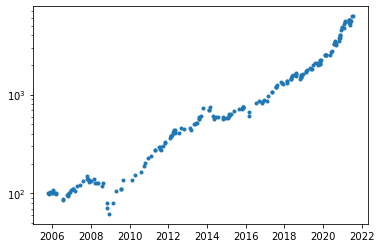

In [2]:
def bu_se_2_profit_fine(dict_pd_stock_bs, pd_stock_bs, n_stock_max=5, n_stock_shift=0):
    time_start = time.time()
    pd_stock_bs_recal_list, pd_stock_bs_ori_list = [], []

    for symbol in dict_pd_stock_bs:
        pd_stock_bs_symbol_ori = dict_pd_stock_bs[symbol].copy()
        pd_stock_bs_ori_list.append(pd_stock_bs_symbol_ori)

    pd_stock_bs_ori = pd.concat(pd_stock_bs_ori_list)
    pd_stock_bs_select = pd_stock_bs_ori

    time_act_list = list(pd_stock_bs_select.loc[pd_stock_bs_select.act].time)
    pd_stock_act_sim = pd_stock_bs_select.loc[pd_stock_bs_select.time.isin(time_act_list)]
    pd_stock_act_sim = pd_stock_act_sim[['time', 'symbol', 'Price', 'weight_final']].drop_duplicates()
    pd_stock_act_sim = pd_stock_act_sim.set_index(['time', 'symbol']).T
    dict_stock_act_ori = pd_stock_act_sim.to_dict()
    dict_stock_act = {}
    dates, symbols = sorted(pd_stock_bs['time'].unique()), list(pd_stock_bs['symbol'].unique())
    for date in dates:
        for symbol in symbols:
            if (date, symbol) in dict_stock_act_ori:
                if date in dict_stock_act:
                    dict_stock_act[date].update({symbol: dict_stock_act_ori[(date, symbol)]})
                else:
                    dict_stock_act[date] = {symbol: dict_stock_act_ori[(date, symbol)]}

    time_start = time.time()
    dict_holding = {'cash': 100}
    asset = 100
    dict_reward = {'asset': [], 'date': [], 'n_stock': [], 'hold_num': [], 'hold_val': []}
    dates = sorted(dict_stock_act.keys())
    #dates = ['2009-11-06', '2009-11-09']
    for i_date, date in zip(range(len(dates)), dates):
        dict_act_ori = dict_stock_act[date]
        stock_value = sum([dict_holding[i] * dict_act_ori[i]['Price'] for i in dict_holding
                           if (i != 'cash') & (dict_holding[i] > 0)])
        asset = stock_value + dict_holding['cash']
        dict_act_keys = sorted(list(dict_act_ori.keys()), key=lambda x: -dict_act_ori[x]['weight_final'])[n_stock_shift:(n_stock_shift+n_stock_max)]
        dict_act = {i: dict_act_ori[i] for i in dict_act_keys}

        weight_final_total = sum([dict_act[i]['weight_final'] for i in dict_act])
        if weight_final_total > 0:
            weight_unit = asset / weight_final_total
            for symbol in dict_holding:
                dict_holding[symbol] = 0
            for symbol in dict_act:
                price = dict_act[symbol]['Price']
                weight_final = dict_act[symbol]['weight_final']
                dict_holding[symbol] = weight_unit * weight_final / price
            dict_holding['cash'] = 0
        else:
            for symbol in dict_holding:
                dict_holding[symbol] = 0
            dict_holding['cash'] = asset
        dict_holding_num = {i:dict_holding[i] for i in dict_holding if (i != 'cash') & (dict_holding[i] > 0)}
        dict_holding_val = {i: (dict_holding[i] * dict_act[i]['Price']) for i in dict_holding
                            if (i != 'cash') & (dict_holding[i] > 0)}
        dict_reward['asset'].append(asset)
        dict_reward['date'].append(date)
        dict_reward['n_stock'].append(len(dict_act))
        dict_reward['hold_num'].append(dict_holding_num)
        dict_reward['hold_val'].append(dict_holding_val)

        time_span = round(time.time() - time_start, 1)
        print(f'\rTime: {time_span} - Trading execution - Progress: {len(dates)}/{i_date + 1}', end='')
    print()

    pd_reward = pd.DataFrame(dict_reward)
    pd_reward['date'] = pd.to_datetime(pd_reward['date'])
    return pd_reward

n_stock_max = 5
n_stock_shift = 0 

pd_reward = bu_se_2_profit_fine(dict_pd_stock_bs=dict_pd_stock_bs, pd_stock_bs=pd_stock_bs, n_stock_max=n_stock_max, n_stock_shift=n_stock_shift)

fig, _ax = plt.subplots(1, 1)
ax = fig.axes
ax[0].plot(pd_reward.date, pd_reward.asset, '.')
ax[0].set_yscale('log')
n_year = (pd_reward.date.iloc[-1] - pd_reward.date.iloc[0]).days / 365
gain = (pd_reward.asset.iloc[-1]/pd_reward.asset.iloc[0])
print(gain ** (1 / n_year))

In [14]:
pd_stock_bs

,time,Price,sec,time_financial,growth_A,growth-1_A,growth_B,growth-1_B,growth_C,growth-1_C,growth_D,growth-1_D,growth_E,growth-1_E,PB_earn,MC_TCA_earn,Book Value,Shares,PB,weight,weight_final,symbol,act
0,2005-10-20,22.79,1,2005-10-20,0.646894,0.231113,0.633274,1.953128,0.864848,0.963127,0.588596,0.165548,0.752284,0.867842,7.973104,7.390620,1614.220,564.736443,7.973104,1.843881,1.843881,JNPR,True
5,2005-10-27,22.47,1,2005-10-20,0.646894,0.231113,0.633274,1.953128,0.864848,0.963127,0.588596,0.165548,0.752284,0.867842,7.973104,7.390620,1614.220,564.736443,7.861151,1.843881,1.843881,JNPR,False
0,2005-10-27,22.80,1,2005-10-27,0.719107,0.338066,0.573585,0.604459,1.030084,0.393635,3.618909,0.764031,0.680328,0.238135,5.209982,13.905501,567.656,129.713925,5.209982,1.615208,1.615208,RRC,True
16,2005-11-11,23.99,1,2005-10-20,0.646894,0.231113,0.633274,1.953128,0.864848,0.963127,0.588596,0.165548,0.752284,0.867842,7.973104,7.390620,1614.220,564.736443,8.392925,1.843881,1.843881,JNPR,False
11,2005-11-11,22.54,1,2005-10-27,0.719107,0.338066,0.573585,0.604459,1.030084,0.393635,3.618909,0.764031,0.680328,0.238135,5.209982,13.905501,567.656,129.713925,5.150570,1.615208,1.615208,RRC,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,2021-07-07,85.83,-1,2021-02-24,1.499402,0.214077,0.061877,0.364642,0.883075,0.223533,1.624745,0.226312,0.215736,0.197413,12.149234,8.475271,2712.615,39.410441,1.246988,1.800074,0.000000,CSGP,True
1352,2021-07-07,447.52,-1,2021-04-30,0.746179,0.463894,0.646422,1.119694,1.036365,0.384129,0.786454,0.456102,0.341739,0.427851,19.815389,10.838042,1884.300,96.705873,22.967581,1.859071,0.000000,DXCM,True
42,2021-07-07,38.32,-1,2021-05-07,1.407756,0.828912,1.743025,1.521764,1.708542,0.910066,1.389751,0.907345,0.896760,1.005185,33.566660,15.293823,121.544,144.777364,45.644940,2.300687,0.000000,EXPI,True
171,2021-07-07,108.10,-1,2021-02-26,0.557658,0.197382,0.984250,0.102735,0.566365,0.738785,5.153241,69.981280,0.206047,0.258374,15.025709,9.541072,660.672,104.396523,17.081493,1.250235,0.000000,FND,True


In [3]:
pd_growth_1.loc[pd_growth_1.time.astype(str).str[:4].isin(['2021'])].sort_values(by='PB')

,exchange_ticker,time,growth_A,growth-1_A,growth_B,growth-1_B,growth_C,growth-1_C,growth_D,growth-1_D,growth_E,growth-1_E,PB,Shares,Book Value,MC_TCA,symbol
64702,NasdaqCM:CORT,2021-02-24,0.684363,0.265977,0.116466,0.176821,0.455138,0.296936,0.765709,0.303797,0.157185,0.223345,5.964943,117.312341,523.338,6.523876,CORT
31777,NasdaqGS:VRTX,2021-04-30,0.551630,0.306683,0.630322,0.534732,0.416144,0.350327,0.579350,0.278777,0.629039,0.687878,7.453124,258.847335,7578.096,6.748093,VRTX
76192,NasdaqCM:MITK,2021-01-29,0.521721,0.179638,0.613509,2.201494,0.572267,0.309761,0.784187,0.194343,0.184846,0.295712,8.015640,42.687378,86.007,7.883285,MITK
47635,NYSE:BABA,2021-02-03,0.530116,0.365031,0.064829,0.341889,0.980238,0.627262,0.587700,0.314494,0.231350,0.394482,8.181685,2705.375000,569728.000,7.798447,BABA
41482,NasdaqGS:NBIX,2021-02-05,0.413975,0.196825,0.545238,0.450419,0.645128,0.259966,0.394812,0.101634,0.310143,0.946848,9.687991,93.943645,1126.200,10.736681,NBIX
45311,NasdaqCM:SLP,2021-01-12,2.638715,0.243556,0.167184,0.259578,4.142131,1.067761,4.748959,0.345054,0.230586,0.216615,11.818557,19.964659,120.208,10.825752,SLP
71426,NasdaqGS:CSGP,2021-02-24,1.499402,0.214077,0.061877,0.364642,0.883075,0.223533,1.624745,0.226312,0.215736,0.197413,12.149234,39.410441,2712.615,8.475271,CSGP
48239,NYSE:FND,2021-02-26,0.557658,0.197382,0.984250,0.102735,0.566365,0.738785,5.153241,69.981280,0.206047,0.258374,15.025709,104.396523,660.672,9.541072,FND
25237,NasdaqGS:MNST,2021-05-07,0.300419,0.176754,0.141351,0.039716,0.482534,0.258230,0.466897,0.240813,0.084953,0.097125,15.734012,528.439000,3064.702,14.042474,MNST
26133,NYSE:CRM,2021-02-26,0.414836,0.359966,0.108520,0.274573,2.298911,5.056069,0.507343,0.463543,0.229418,0.308412,18.026987,921.000000,11061.000,9.109439,CRM


1.302417478939792


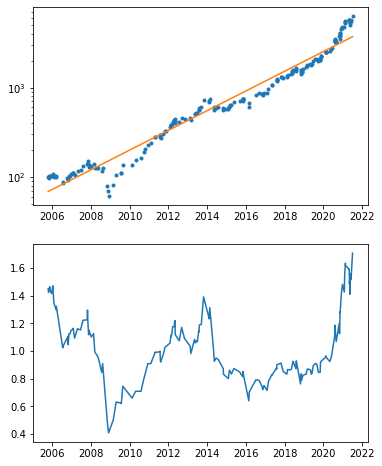

In [92]:
model = LinearRegression().fit(pd_reward[['date']], np.log10(pd_reward.asset))
asset_predict = 10 ** model.predict(np.float64(pd_reward[['date']]))

fig, _ax = plt.subplots(2, 1, figsize=(6, 8))
ax = fig.axes
ax[0].plot(pd_reward.date, pd_reward.asset, '.')
ax[0].plot(pd_reward.date, asset_predict)
ax[0].set_yscale('log')

ax[1].plot(pd_reward.date, pd_reward.asset / asset_predict)
n_year = (pd_reward.date.iloc[-1] - pd_reward.date.iloc[0]).days / 365
gain = (pd_reward.asset.iloc[-1]/pd_reward.asset.iloc[0])
print(gain ** (1 / n_year))

In [81]:

symbols = list(pd_stock_bs.symbol.unique())
pd_temp_list = []
for symbol in symbols:
    pd_temp = pd_stock_bs.loc[pd_stock_bs.symbol == symbol]
    pd_temp_diff = pd_temp.weight_final.diff()
    pd_temp_list.append(pd_temp.loc[pd_temp_diff.loc[(pd_temp_diff.abs()>0)|(pd_temp_diff.isna())].index])
pd_stock_temp_final = pd.concat(pd_temp_list).sort_values(by=['time', 'symbol'])

usd_total = 90000
_dict_recommend_val, _dict_recommend_num = pd_reward.iloc[-2].hold_val, pd_reward.iloc[-2].hold_num
_keys = list(_dict_recommend_val.keys())
dict_recommend = {'symbol': _keys, 'num': [_dict_recommend_num[i] for i in _dict_recommend_num]}
pd_recommend = pd.DataFrame(dict_recommend)
pd_price_info = pd_stock_bs.loc[pd_stock_bs.time == pd_stock_bs.time.max()]
pd_recommend = pd_recommend.merge(pd_price_info, on='symbol', how='inner')[['symbol', 'Price', 'num']].drop_duplicates()
pd_recommend['usd'] = pd_recommend['Price'] * pd_recommend['num']
_rate = usd_total / pd_recommend.usd.sum()
pd_recommend[['usd', 'num']] = pd_recommend[['usd', 'num']] * _rate
pd_recommend = pd_recommend.sort_values(by='usd', ascending=False)
pd_recommend['usd_int'] = 0
pd_recommend['num_int'] = pd_recommend['num'].round()
pd_recommend['usd_int'] = pd_recommend['Price'] * pd_recommend['num']
pd_recommend = pd_recommend.set_index('symbol')
pd_recommend_int = pd_recommend[['num_int', 'usd_int']].copy()
pd_recommend_int['price'] = pd_recommend_int['usd_int'] / pd_recommend_int['num_int']
pd_recommend_int['usd_int'].sum()
pd_recommend_int

,num_int,usd_int,price
symbol,,,
EXPI,631.0,25001.161075,39.621491
CSBR,1819.0,18132.042069,9.968137
OKTA,75.0,17966.132000,239.548427
POOL,32.0,14807.795683,462.743615
ROKU,32.0,14092.869174,440.402162


In [62]:
pd_growth_1.loc[pd_growth_1.symbol == 'EXPI']

,exchange_ticker,time,growth_A,growth-1_A,growth_B,growth-1_B,growth_C,growth-1_C,growth_D,growth-1_D,growth_E,growth-1_E,PB,Shares,Book Value,MC_TCA,symbol
9784,NasdaqGM:EXPI,2021-05-07,1.407756,0.828912,1.743025,1.521764,1.708542,0.910066,1.389751,0.907345,0.89676,1.005185,33.56666,144.777364,121.544,15.293823,EXPI


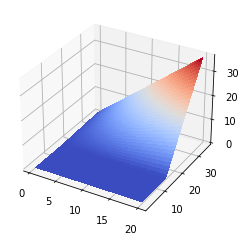

In [68]:

def plot_score(min_growth=0.3, max_growth=20, growth_slope=35, max_pb_1=15, max_pb_2=35):
    from matplotlib import cm

    growth, pb = np.meshgrid(np.linspace(min_growth, max_growth), np.linspace(2, max_pb_2))
    dict_input = {'growth_C': growth, 'PB': pb}
    score = cal_trading_weight(dict_input, min_growth, max_growth, growth_slope, max_pb_1, max_pb_2)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(growth, pb, score, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
plot_score()